In [56]:
import mdtraj as mda
import matplotlib.pyplot as plt
import numpy as np
from ase.io import read
from tqdm.notebook import tqdm

data_path = './data/dump-surface.lammpstrj'

layer_num = 40
min_frame = 1000
max_frame = 2000
frame_step = 10

# Load Data

In [57]:
traj = read(data_path, index=':')

indices = list(range(min_frame, min(len(traj), max_frame), frame_step))
num_frames = len(indices)

print(f'Total frames: {num_frames}')


Total frames: 100


In [58]:
# convert to numpy array for easier processing
A = np.zeros((num_frames, 3, traj[0].get_positions().shape[0] // 3, 3), dtype=np.float64)

for idx, i in enumerate(tqdm(indices, desc='Reading frames')):
	frame = traj[i]
	box = traj[0].get_cell()

	positions = frame.get_positions()

	for x in range(positions.shape[0] // 3) :
		O = positions[3*x]
		H1 = positions[3*x + 1]
		H2 = positions[3*x + 2]

		A[idx, 0, x, :] = O
		A[idx, 1, x, :] = H1
		A[idx, 2, x, :] = H2
			

Reading frames:   0%|          | 0/100 [00:00<?, ?it/s]

# 计算氢键

距离 $<3.5$ 任何一个H-O-O 角度小于 $30^{\circ}$ 视为氢键

In [59]:
hb_dis = 3.5
hb_rad = np.deg2rad(30)

hb_m_cnt = np.zeros((A.shape[0], A.shape[2]))
hb_layer_cnt = np.zeros((A.shape[0], layer_num))
m_layer_cnt = np.zeros((A.shape[0], layer_num))

def min_image(dr, box_lengths):
    return dr - box_lengths * np.round(dr / box_lengths)

pBar = tqdm(total=A.shape[0] * A.shape[2], desc='Calculating H-bonds')
for t in range(A.shape[0]) :
	box = traj[indices[t]].get_cell()
	box = np.array([box[0][0], box[1][1], box[2][2]])
	for x in range(A.shape[2]) :
		O = A[t, 0, x, :]
		H1 = A[t, 1, x, :]
		H2 = A[t, 2, x, :]

		Os = A[t, 0, :, :]
		H1s = A[t, 1, :, :]
		H2s = A[t, 2, :, :]

		dis = np.linalg.norm(min_image(Os - O, box), axis=1)
		mask = dis < hb_dis
		mask[x] = False

		Os = Os[mask]
		H1s = H1s[mask]
		H2s = H2s[mask]

		uH1, uH2 = H1 - O, H2 - O
		uH3, uH4 = Os - O, Os - O

		uH1, uH2 = min_image(uH1, box), min_image(uH2, box)
		uH3, uH4 = min_image(uH3, box), min_image(uH4, box)

		n1, n2, n3, n4 = np.linalg.norm(uH1), np.linalg.norm(uH2), np.linalg.norm(uH3, axis=1), np.linalg.norm(uH4, axis=1)

		cos_ang1 = np.dot(uH3, uH1) / (n1 * n3)
		cos_ang2 = np.dot(uH4, uH2) / (n2 * n4)

		ang1 = np.acos(np.clip(cos_ang1, -1.0, 1.0))
		ang2 = np.acos(np.clip(cos_ang2, -1.0, 1.0))

		num_hb = np.sum((ang1 < hb_rad) | (ang2 < hb_rad))

		uH1, uH2 = H1s - Os, H2s - Os
		uH3, uH4 = O - Os, O - Os

		uH1, uH2 = min_image(uH1, box), min_image(uH2, box)
		uH3, uH4 = min_image(uH3, box), min_image(uH4, box)

		n1, n2, n3, n4 = np.linalg.norm(uH1, axis=1), np.linalg.norm(uH2, axis=1), np.linalg.norm(uH3, axis=1), np.linalg.norm(uH4, axis=1)

		cos_ang1 = np.sum(uH1 * uH3, axis=1) / (n1 * n3)
		cos_ang2 = np.sum(uH2 * uH4, axis=1) / (n2 * n4)

		ang1 = np.acos(np.clip(cos_ang1, -1.0, 1.0))
		ang2 = np.acos(np.clip(cos_ang2, -1.0, 1.0))

		num_hb += np.sum((ang1 < hb_rad)| (ang2 < hb_rad))

		hb_m_cnt[t, x] = num_hb

		pBar.update(1)
pBar.close()




Calculating H-bonds:   0%|          | 0/105600 [00:00<?, ?it/s]

In [60]:
# contribute to each layer

hb_layer_cnt = np.zeros((A.shape[0], layer_num))
m_layer_cnt = np.zeros((A.shape[0], layer_num))

pBar = tqdm(total=A.shape[0] * A.shape[2], desc='Calculating layer H-bonds')
for t in range(hb_m_cnt.shape[0]) :
	box = traj[indices[t]].get_cell()
	for x in range(hb_m_cnt.shape[1]) :
		pBar.update(1)
		z = A[t, 0, x, 2]
		layer = int((z + box[2][2] / 2) / box[2][2] * layer_num)
		hb_layer_cnt[t, layer] += hb_m_cnt[t, x]
		m_layer_cnt[t, layer] += 1

pBar.close()


Calculating layer H-bonds:   0%|          | 0/105600 [00:00<?, ?it/s]

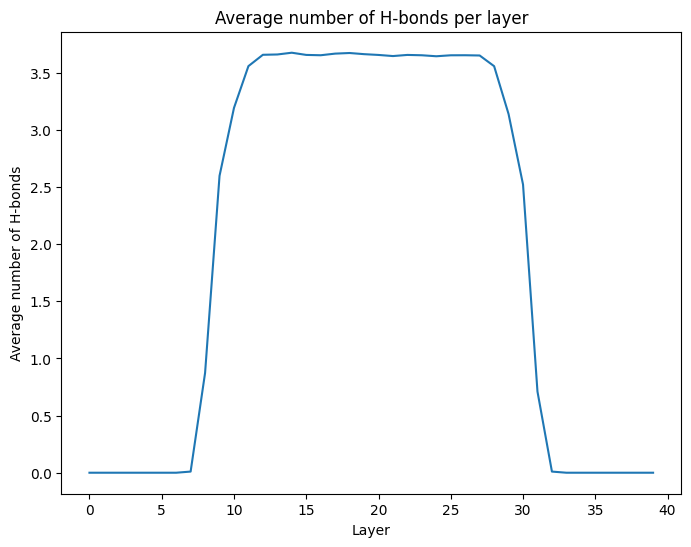

In [61]:
# 平均每一层的氢键数量
hb_layer_avg = np.mean(hb_layer_cnt / (m_layer_cnt + 1e-12), axis=0)
plt.figure(figsize=(8,6))
plt.plot(range(layer_num), hb_layer_avg)
plt.xlabel('Layer')
plt.ylabel('Average number of H-bonds')
plt.title('Average number of H-bonds per layer')
plt.show()

In [62]:
# calculate angle of 1/2 * (H1-O + H2-O) with z-axis

z_ang = np.zeros((A.shape[0], A.shape[2]))
pBar = tqdm(total=A.shape[0] * A.shape[2], desc='Calculating dipole angles')
for t in range(A.shape[0]) :
	for x in range(A.shape[2]) :
		pBar.update(1)
		O = A[t, 0, x, :]
		H1 = A[t, 1, x, :]
		H2 = A[t, 2, x, :]

		H_center = (H1 + H2) / 2
		uH = H_center - O
		uH /= np.linalg.norm(uH)

		cos_ang = uH[2]  # z-axis
		z_ang[t, x] = cos_ang
pBar.close()



Calculating dipole angles:   0%|          | 0/105600 [00:00<?, ?it/s]

Calculating layer dipole angles:   0%|          | 0/105600 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Average dipole angle per layer')

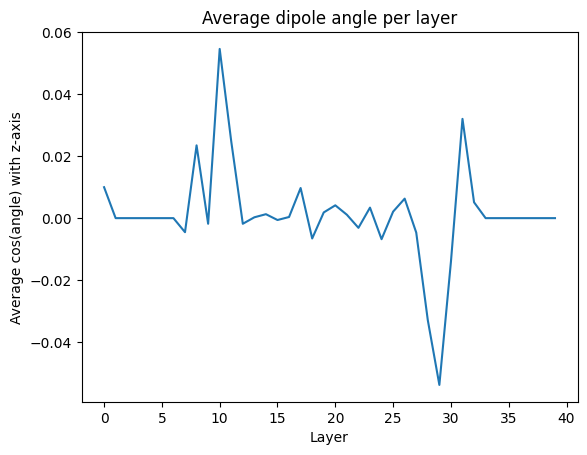

In [63]:
# z_ang_layer = np.array([np.nan] * (A.shape[0] * layer_num)).reshape(A.shape[0], layer_num)
z_ang_layer = np.zeros((A.shape[0], layer_num))
pBar = tqdm(total=A.shape[0] * A.shape[2], desc='Calculating layer dipole angles')
for t in range(z_ang.shape[0]) :
	box = traj[indices[t]].get_cell()
	for x in range(z_ang.shape[1]) :
		pBar.update(1)
		z = A[t, 0, x, 2]
		layer = int((z + box[2][2] / 2) / box[2][2] * layer_num)
		if (z_ang_layer[:, layer] == np.nan).any():
			z_ang_layer[:, layer] = np.zeros(A.shape[0])
		z_ang_layer[t, layer] += z_ang[t, x]
pBar.close()

z_ang_layer_avg = z_ang_layer / (m_layer_cnt + 1e-12)
plt.plot(range(layer_num), z_ang_layer_avg.mean(axis=0))
plt.xlabel('Layer')
plt.ylabel('Average cos(angle) with z-axis')
plt.title('Average dipole angle per layer')

Calculating solid angles:   0%|          | 0/105600 [00:00<?, ?it/s]

Calculating layer solid angles:   0%|          | 0/105600 [00:00<?, ?it/s]

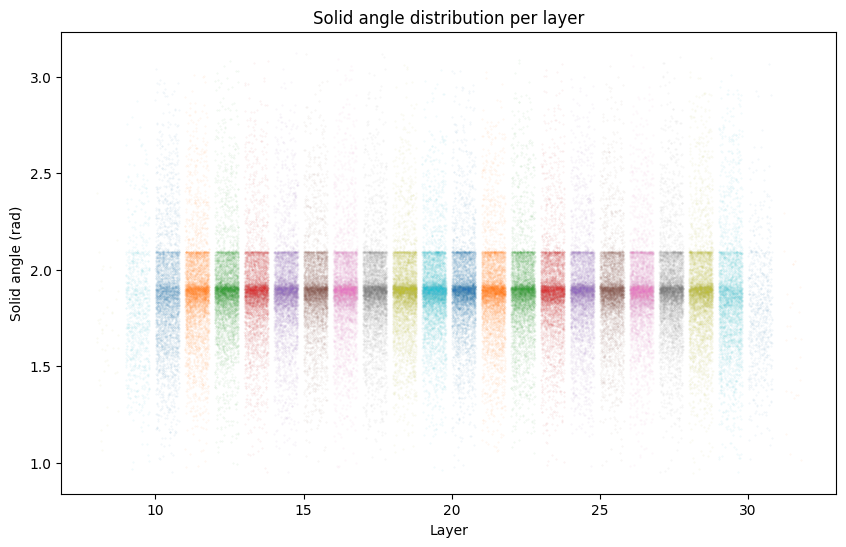

In [64]:
s_angle = np.zeros((A.shape[0], A.shape[2]))
# s_angle = [[ [] for _ in range(A.shape[2]) ] for _ in range(A.shape[0]) ]
pBar = tqdm(total=A.shape[0] * A.shape[2], desc='Calculating solid angles')

for t in range(A.shape[0]) :
	box = traj[indices[t]].get_cell()
	box = np.array([box[0][0], box[1][1], box[2][2]])
	for x in range(A.shape[2]) :
		pBar.update(1)
		O = A[t, 0, x, :]
		Os = A[t, 0, :, :]

		Os = min_image(Os - O, box)
		dis = np.linalg.norm(Os, axis=1)

		mask = (dis < 3.0)
		mask[x] = False

		if np.sum(mask) < 2 :
			s_angle[t, x] = np.nan
			# s_angle[t][x] = []
			continue
		Os = Os[mask]
		us = Os / np.linalg.norm(Os, axis=1, keepdims=True)
		cos_theta = us @ us.T
		theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))
		angle_sum = 0.0
		angle_this = []
		for i in range(theta.shape[0]) :
			for j in range(i+1, theta.shape[1]) :
				angle_sum += theta[i, j]
				angle_this.append(theta[i, j])
		avg_angle = angle_sum / (theta.shape[0] * (theta.shape[0] - 1) / 2 + 1e-12)

		s_angle[t, x] = avg_angle
		# s_angle[t][x] = angle_this
pBar.close()

s_angle_layer = [ [ [] for _ in range(layer_num) ] for _ in range(A.shape[0]) ]
pBar = tqdm(total=A.shape[0] * A.shape[2], desc='Calculating layer solid angles')
	
for t in range(A.shape[0]) :
	box = traj[indices[t]].get_cell()
	for x in range(A.shape[2]) :
		pBar.update(1)
		if np.isnan(s_angle[t, x]) :
			continue
		z = A[t, 0, x, 2]
		layer = int((z + box[2][2] / 2) / box[2][2] * layer_num)
		# s_angle_layer[t][layer].extend(s_angle[t][x])
		s_angle_layer[t][layer].append(s_angle[t, x])
pBar.close()

# use scatter to plot the solid angle distribution per layer
plt.figure(figsize=(10,6))
for layer in range(layer_num) :
	values = [ s_angle_layer[t][layer] for t in range(A.shape[0]) ]
	values = np.concatenate(values)
	# values = []
	# for t in range(A.shape[0]) :
		# values.extend(s_angle_layer[t][layer])
	# values = np.array(values)
	xs = np.full_like(values, layer)
	plt.scatter(xs + np.random.random(values.shape[0]) * 0.8, values, alpha=0.1, s=0.1)
# plt.hlines(np.acos(-1/3), 0, layer_num, colors='blue', linestyles='dashed', label='Ideal tetrahedral angle')
plt.xlabel('Layer')
plt.ylabel('Solid angle (rad)')
plt.title('Solid angle distribution per layer')
plt.show()

Calculating difference between max hbond distance min no-bond distance:   0%|          | 0/105600 [00:00<?, ?i…

Calculating layer distance differences:   0%|          | 0/105600 [00:00<?, ?it/s]

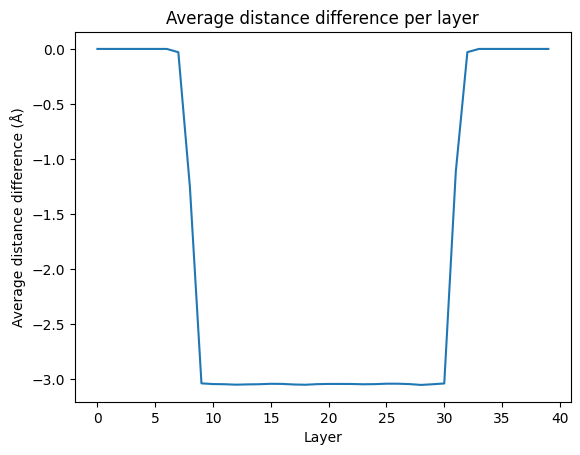

In [65]:
dis_diff = np.zeros((A.shape[0], A.shape[2]))
pBar = tqdm(total=A.shape[0] * A.shape[2], desc='Calculating difference between max hbond distance min no-bond distance')
for t in range(A.shape[0]) :
	box = traj[indices[t]].get_cell()
	box = np.array([box[0][0], box[1][1], box[2][2]])
	for x in range(A.shape[2]) :
		pBar.update(1)
		O = A[t, 0, x, :]
		H1 = A[t, 1, x, :]
		H2 = A[t, 2, x, :]
		Os = A[t, 0, :, :]
		H1s = A[t, 1, :, :]
		H2s = A[t, 2, :, :]

		dis = np.linalg.norm(min_image(Os - O, box), axis=1)
		mask = dis < hb_dis
		mask[x] = False

		Os = Os[mask]
		H1s = H1s[mask]
		H2s = H2s[mask]

		no_bond_dis = dis[~mask]
		hbond_dis = dis[mask]

		if hbond_dis.shape[0] == 0 or no_bond_dis.shape[0] == 0 :
			dis_diff[t, x] = np.nan
			continue

		min_no_bond = np.min(no_bond_dis)

		max_hbound = -np.inf

		u1, u2 = H1 - O, H2 - O
		u3, u4 = Os - O, Os - O
		u1, u2 = min_image(u1, box), min_image(u2, box)
		u3, u4 = min_image(u3, box), min_image(u4, box)
		n1, n2, n3, n4 = np.linalg.norm(u1), np.linalg.norm(u2), np.linalg.norm(u3, axis=1), np.linalg.norm(u4, axis=1)
		cos_ang1 = np.dot(u3, u1) / (n1 * n3)
		cos_ang2 = np.dot(u4, u2) / (n2 * n4)
		ang1 = np.acos(np.clip(cos_ang1, -1.0, 1.0))
		ang2 = np.acos(np.clip(cos_ang2, -1.0, 1.0))
		mask2 = (ang1 < hb_rad) | (ang2 < hb_rad)

		if mask2.sum() != 0 :
			max_hbond = np.max(hbond_dis[mask2])

		u1, u2 = H1s - Os, H2s - Os
		u3, u4 = O - Os, O - Os
		u1, u2 = min_image(u1, box), min_image(u2, box)
		u3, u4 = min_image(u3, box), min_image(u4, box)
		n1, n2, n3, n4 = np.linalg.norm(u1, axis=1), np.linalg.norm(u2, axis=1), np.linalg.norm(u3, axis=1), np.linalg.norm(u4, axis=1)
		cos_ang1 = np.sum(u1 * u3, axis=1) / (n1 * n3)
		cos_ang2 = np.sum(u2 * u4, axis=1) / (n2 * n4)
		ang1 = np.acos(np.clip(cos_ang1, -1.0, 1.0))
		ang2 = np.acos(np.clip(cos_ang2, -1.0, 1.0))
		mask2 = (ang1 < hb_rad) | (ang2 < hb_rad)

		if mask2.sum() != 0 :
			max_hbond2 = np.max(hbond_dis[mask2])
			max_hbond = max(max_hbond, max_hbond2)

		if max_hbond != -np.inf :
			dis_diff[t, x] = min_no_bond - max_hbond
pBar.close()

dis_diff_layer = np.zeros((A.shape[0], layer_num))
dis_diff_m = np.zeros((A.shape[0], layer_num))
pBar = tqdm(total=A.shape[0] * A.shape[2], desc='Calculating layer distance differences')
for t in range(A.shape[0]) :
	box = traj[indices[t]].get_cell()
	for x in range(A.shape[2]) :
		pBar.update(1)
		z = A[t, 0, x, 2]
		layer = int((z + box[2][2] / 2) / box[2][2] * layer_num)
		if np.isnan(dis_diff[t, x]) :
			continue
		dis_diff_layer[t, layer] += dis_diff[t, x]
		dis_diff_m[t, layer] += 1
pBar.close()
dis_diff_layer_avg = dis_diff_layer / (dis_diff_m + 1e-12)
plt.plot(range(layer_num), dis_diff_layer_avg.mean(axis=0))
plt.xlabel('Layer')
plt.ylabel('Average distance difference (Å)')
plt.title('Average distance difference per layer')
plt.show()